# Importing Libraries

In [1]:
!pip install plotly shap

     |████████████████████████████████| 564 kB 27.6 MB/s 


In [2]:
# packages
import time
import random
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import collections
import ast
import seaborn as sns
import scipy.stats as stats
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from scipy.ndimage.filters import gaussian_filter
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from datetime import datetime,timedelta
from tqdm import tqdm
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM, GRU
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost
import os
import shap
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Instructions for updating:
non-resource variables are not supported in the long term


# Data Loading

In [3]:
df_mt3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Research/electricity_321.csv', parse_dates={'timestamp' : [0]}, infer_datetime_format=True) 
df_mt3 = df_mt3.iloc[:, [0,4]]
df_mt3.head()

,timestamp,MT_3
0,2012-01-01 00:00:00,415.0
1,2012-01-01 01:00:00,556.0
2,2012-01-01 02:00:00,560.0
3,2012-01-01 03:00:00,443.0
4,2012-01-01 04:00:00,346.0


In [4]:
df_mt3 = df_mt3.dropna()
df_mt3 = df_mt3[df_mt3.MT_3 != 0]
df_mt3.shape

(21065, 2)

# Visualization

In [5]:
df_viz = df_mt3.copy()
df_viz.set_index(df_viz.timestamp, inplace=True)
df_viz.drop('timestamp', axis=1, inplace=True)
df_viz.head()

,MT_3
timestamp,
2012-01-01 00:00:00,415.0
2012-01-01 01:00:00,556.0
2012-01-01 02:00:00,560.0
2012-01-01 03:00:00,443.0
2012-01-01 04:00:00,346.0


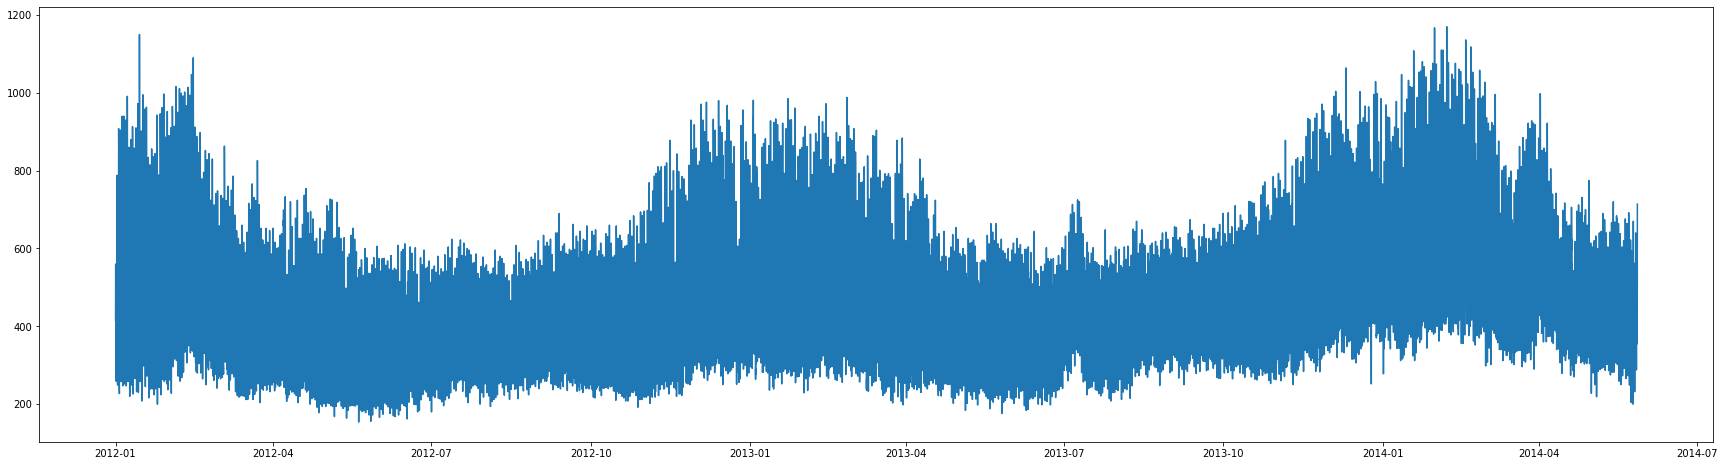

In [6]:
plt.figure(figsize=(30,8))
plt.plot(df_viz.index, df_viz['MT_3'])
plt.show()

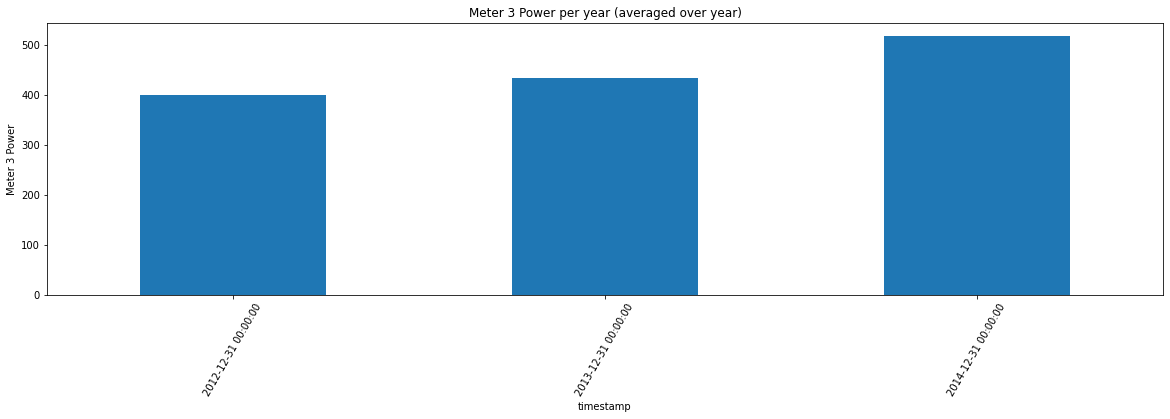

In [7]:
plt.figure(figsize=(20,5))
df_viz.MT_3.resample('Y').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Meter 3 Power')
plt.title('Meter 3 Power per year (averaged over year)')
plt.show()

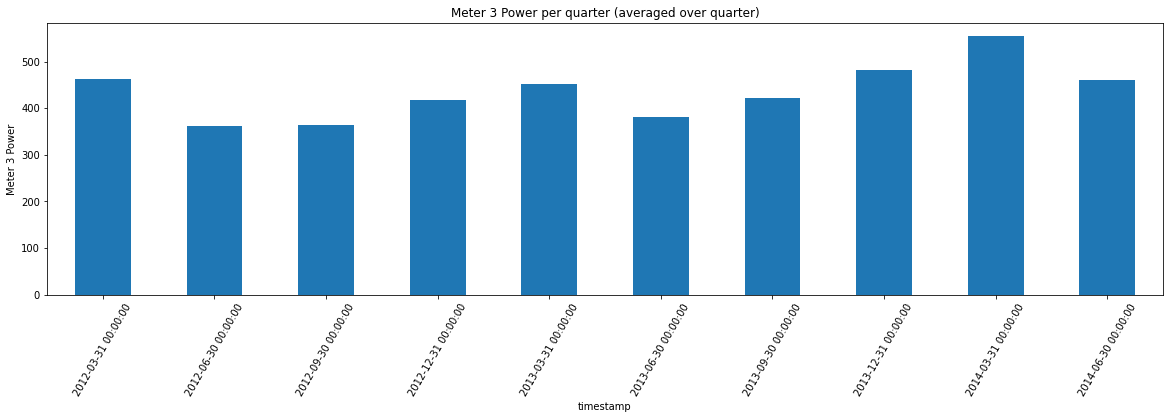

In [8]:
plt.figure(figsize=(20,5))
df_viz.MT_3.resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Meter 3 Power')
plt.title('Meter 3 Power per quarter (averaged over quarter)')
plt.show()

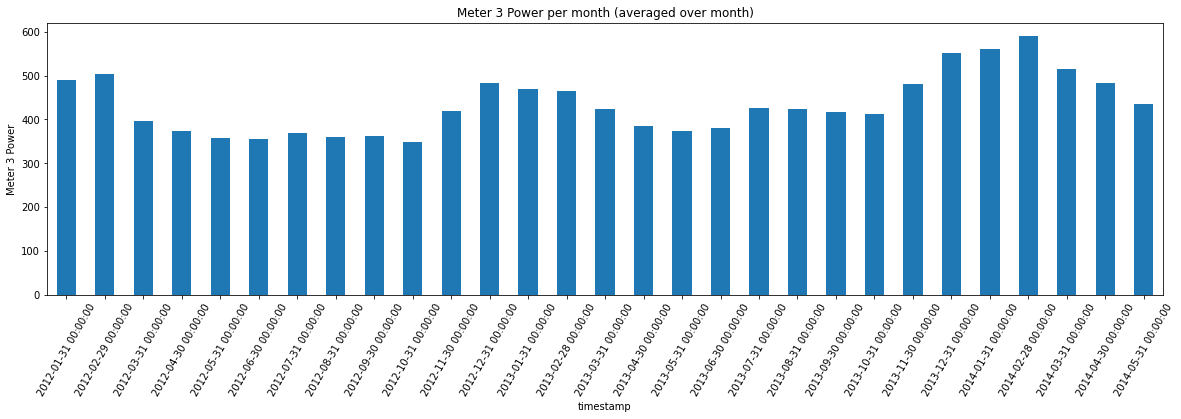

In [9]:
plt.figure(figsize=(20,5))
df_viz.MT_3.resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Meter 3 Power')
plt.title('Meter 3 Power per month (averaged over month)')
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

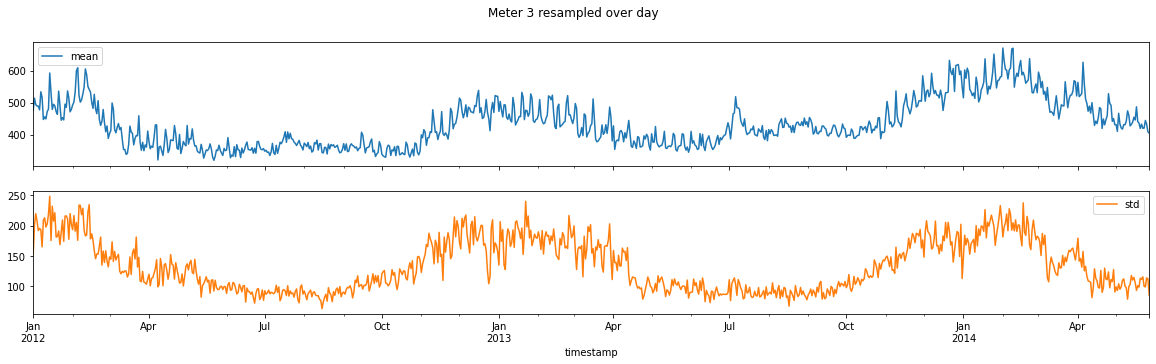

In [10]:
r = df_viz.MT_3.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Meter 3 resampled over day')
plt.show()

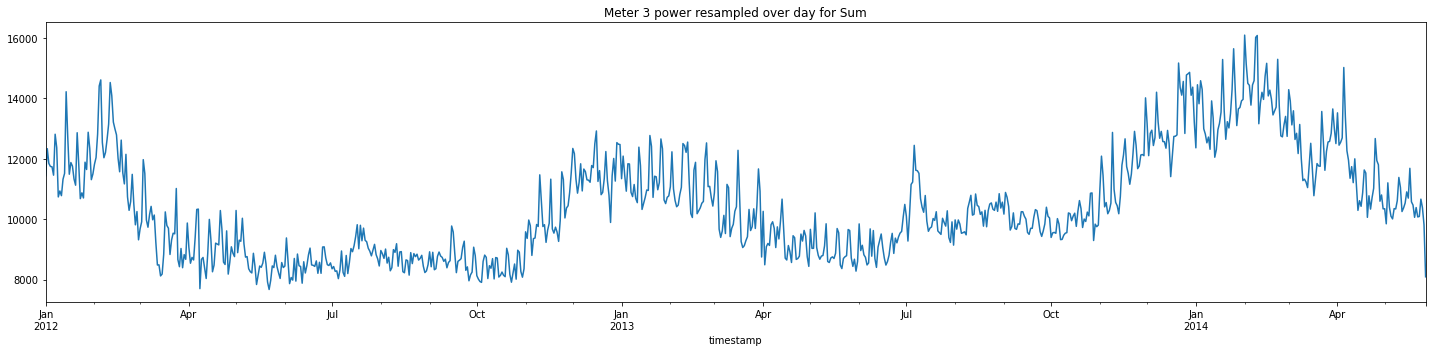

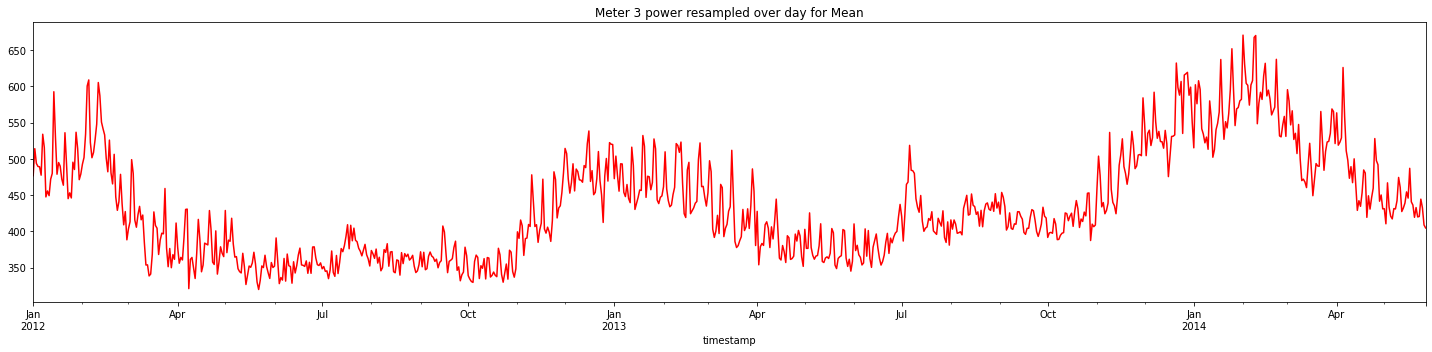

In [11]:
df_viz.MT_3.resample('D').sum().plot(title='Meter 3 power resampled over day for Sum') 
plt.tight_layout()
plt.show() 

df_viz.MT_3.resample('D').mean().plot(title='Meter 3 power resampled over day for Mean', color='r') 
plt.tight_layout()
plt.show() 

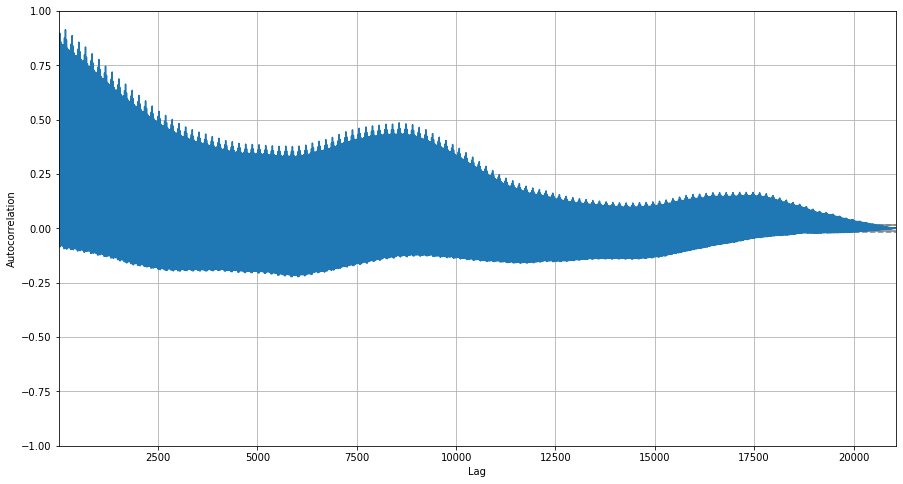

In [12]:
plt.figure(figsize=(15,8))
autocorrelation_plot(df_viz['MT_3'])
plt.show()

# ADF Test

In [13]:
result = adfuller(df_mt3.MT_3.dropna())
print('p-value: %f' % result[1])

p-value: 0.000003


As p-value is <= 0.05, the data is stationary

# Feature Engineering/Extraction

In [14]:
# Extracts features and returns new dataframe
def extract_ts_features(df, primary=True, cyclic=True):
  if primary:
    df['hour'] = [i.hour for i in df['timestamp']]
    df['month'] = [i.month for i in df['timestamp']]
    df['year'] = [i.year for i in df['timestamp']]
    df['day_of_week'] = [i.dayofweek for i in df['timestamp']]
    df['day_of_year'] = [i.dayofyear for i in df['timestamp']]

  if cyclic:
    # turn time data to be cyclic
    df['dow_sin'] = np.sin(df.day_of_week * (2 * np.pi / 7))
    df['dow_cos'] = np.cos(df.day_of_week * (2 * np.pi / 7))
    df['hour_sin'] = np.sin(df.hour * (2 * np.pi / 24))
    df['hour_cos'] = np.cos(df.hour * (2 * np.pi / 24))

  return df

In [15]:
df_mt3 = extract_ts_features(df_mt3)
df_mt3.shape

(21065, 11)

In [16]:
data_split = 0.85

In [17]:
Dataset = df_mt3.copy()
Dataset_time = df_mt3['timestamp']

In [18]:
df_mt3.drop('timestamp', axis=1, inplace=True)
df_mt3

,MT_3,hour,month,year,day_of_week,day_of_year,dow_sin,dow_cos,hour_sin,hour_cos
0,415.0,0,1,2012,6,1,-0.781831,0.62349,0.000000,1.000000e+00
1,556.0,1,1,2012,6,1,-0.781831,0.62349,0.258819,9.659258e-01
2,560.0,2,1,2012,6,1,-0.781831,0.62349,0.500000,8.660254e-01
3,443.0,3,1,2012,6,1,-0.781831,0.62349,0.707107,7.071068e-01
4,346.0,4,1,2012,6,1,-0.781831,0.62349,0.866025,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...
21063,376.0,15,5,2014,1,147,0.781831,0.62349,-0.707107,-7.071068e-01
21064,368.0,16,5,2014,1,147,0.781831,0.62349,-0.866025,-5.000000e-01
21065,394.0,17,5,2014,1,147,0.781831,0.62349,-0.965926,-2.588190e-01
21066,469.0,18,5,2014,1,147,0.781831,0.62349,-1.000000,-1.836970e-16


## Correlation Plots

In [19]:
df_mt3.corr()

,MT_3,hour,month,year,day_of_week,day_of_year,dow_sin,dow_cos,hour_sin,hour_cos
MT_3,1.000000,0.561902,-0.108570,0.249339,0.078679,-0.109273,-0.084768,-0.010733,-0.521830,0.257580
hour,0.561902,1.000000,-0.000109,-0.000400,0.000598,-0.000110,-0.000542,-0.000051,-0.775965,-0.102221
month,-0.108570,-0.000109,1.000000,-0.296503,0.001911,0.996558,-0.008598,0.006338,0.000002,0.000219
year,0.249339,-0.000400,-0.296503,1.000000,-0.000139,-0.299818,0.001436,-0.002702,0.000253,-0.000420
day_of_week,0.078679,0.000598,0.001911,-0.000139,1.000000,0.001078,-0.733880,-0.353799,-0.000234,-0.000088
day_of_year,-0.109273,-0.000110,0.996558,-0.299818,0.001078,1.000000,-0.007818,0.006025,0.000011,0.000176
dow_sin,-0.084768,-0.000542,-0.008598,0.001436,-0.733880,-0.007818,1.000000,-0.000046,0.000231,-0.000011
dow_cos,-0.010733,-0.000051,0.006338,-0.002702,-0.353799,0.006025,-0.000046,1.000000,0.000092,-0.000350
hour_sin,-0.521830,-0.775965,0.000002,0.000253,-0.000234,0.000011,0.000231,0.000092,1.000000,0.000082
hour_cos,0.257580,-0.102221,0.000219,-0.000420,-0.000088,0.000176,-0.000011,-0.000350,0.000082,1.000000


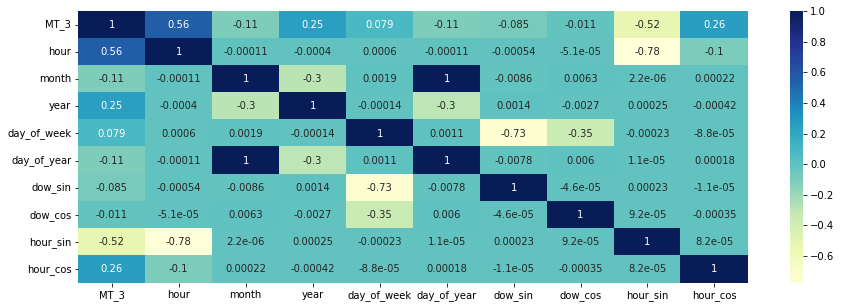

In [20]:
plt.figure(figsize=(15,5))
sns.heatmap(df_mt3.corr(), cmap="YlGnBu", annot=True)
plt.show()

# No Lag

## LSTM

In [12]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(df_mt3.iloc[:,1:])
Y_data = Y_scaler.fit_transform(df_mt3['MT_3'].to_numpy().reshape(-1,1))

data_series = Dataset["MT_3"].copy()
n_train = int(len(df_mt3) * data_split)
n_test = (len(df_mt3) - n_train)
print(n_train, n_test)

X_train = X_data[:-n_test]
y_train = Y_data[:-n_test]
train_dates_lstm = Dataset_time[:-n_test]

X_test = X_data[-n_test:]
y_test_LSTM = Y_data[-n_test:]
test_dates_lstm = Dataset_time[-n_test:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test_LSTM.shape)

17905 3160
(17905, 9, 1) (17905, 1) (3160, 9, 1) (3160, 1)


In [13]:
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 9, 200)            161600    
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((X_test, y_test_LSTM))
val_data = val_data.batch(batch_size).repeat() 

In [ ]:
model_path = 'LSTM_Multivariate_No_Lag.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 
history = model.fit(train_data,epochs=100,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 8s 76ms/step - loss: 0.0604 - val_loss: 0.1703
Epoch 2/100
100/100 [==============================] - 8s 75ms/step - loss: 0.0621 - val_loss: 0.0817
Epoch 3/100
100/100 [==============================] - 8s 75ms/step - loss: 0.0624 - val_loss: 0.1248
Epoch 4/100
100/100 [==============================] - 8s 77ms/step - loss: 0.0583 - val_loss: 0.1675
Epoch 5/100
100/100 [==============================] - 8s 75ms/step - loss: 0.0629 - val_loss: 0.0838
Epoch 6/100
100/100 [==============================] - 8s 76ms/step - loss: 0.0579 - val_loss: 0.1193
Epoch 7/100
100/100 [==============================] - 8s 77ms/step - loss: 0.0587 - val_loss: 0.0787
Epoch 8/100
100/100 [==============================] - 8s 76ms/step - loss: 0.0582 - val_loss: 0.1610
Epoch 9/100
100/100 [==============================] - 8s 77ms/step - loss: 0.0592 - val_loss: 0.0835
Epoch 10/100
100/100 [==============================] - 8s 76ms/step - loss: 0.061

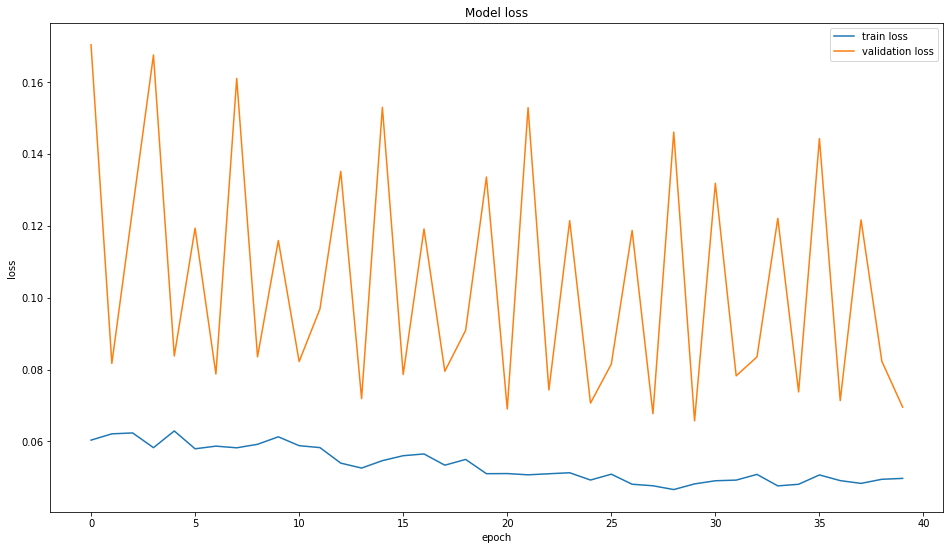

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

In [20]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Research/LSTM_Multivariate_No_Lag.h5')
model.evaluate(X_test, y_test_LSTM)

0.06552249668519708

In [21]:
y_pred_LSTM = model.predict(X_test)
pred_Inverse_LSTM = Y_scaler.inverse_transform(np.reshape(y_pred_LSTM, (y_pred_LSTM.shape[0], y_pred_LSTM.shape[1])))
y_test_inverse_LSTM = np.array(df_mt3.iloc[-n_test:,0])

### Deep SHAP

In [22]:
explainer = shap.DeepExplainer(model, X_train[:1000])
shap_values = explainer.shap_values(X_test[:100], check_additivity=False)

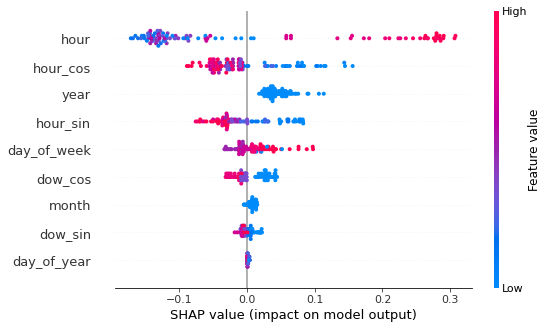

In [23]:
shap.summary_plot(np.array(shap_values[0]).reshape(100,9), features=np.array(X_test[:100]).reshape(100,9), feature_names=df_mt3.columns[df_mt3.columns != 'MT_3'])

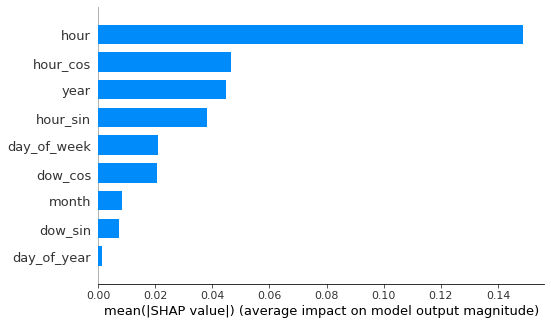

In [24]:
shap.summary_plot(np.array(shap_values[0]).reshape(100,9), features=np.array(X_test[:100]).reshape(100,9), feature_names=df_mt3.columns[df_mt3.columns != 'MT_3'], plot_type='bar')

## GRU

In [26]:
model = Sequential()
model.add(GRU(200, activation='relu', return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(GRU(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 9, 200)            121800    
                                                                 
 gru_1 (GRU)                 (None, 100)               90600     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 212,501
Trainable params: 212,501
Non-trainable params: 0
_________________________________________________________________


In [27]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((X_test, y_test_LSTM))
val_data = val_data.batch(batch_size).repeat() 

In [28]:
model_path = 'GRU_Multivariate_No_Lag.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 
history = model.fit(train_data,epochs=100,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Train on 100 steps, validate on 50 steps
Epoch 1/100
100/100 [==============================] - 11s 102ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1173 - val_loss: 0.1691
Epoch 2/100
100/100 [==============================] - 11s 114ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1050 - val_loss: 0.1129
Epoch 3/100
100/100 [==============================] - 14s 137ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1005 - val_loss: 0.1947
Epoch 4/100
100/100 [==============================] - 14s 137ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0933 - val_loss: 0.1704
Epoch 5/100
100/100 [==============================] - 15s 150ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0957 - val_loss: 0.1156
Epoch 6/100
100/100 [==============================] - 11s 112ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0928 - val_loss: 0.1105
Epoch 7/100
100/100 [==============================] - 11s 112ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0912 - val_loss: 0.1195
Epoch 8

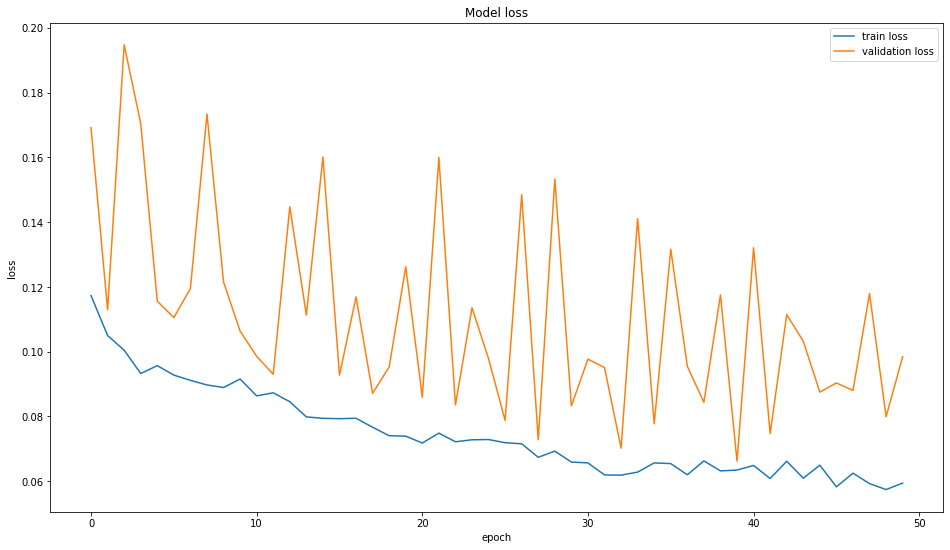

In [29]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

In [32]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Research/GRU_Multivariate_No_Lag.h5')
model.evaluate(X_test, y_test_LSTM)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


0.06593464015971257

In [33]:
y_pred_GRU = model.predict(X_test)
pred_Inverse_GRU = Y_scaler.inverse_transform(np.reshape(y_pred_GRU, (y_pred_GRU.shape[0], y_pred_GRU.shape[1])))
y_test_inverse_GRU = np.array(df_mt3.iloc[-n_test:,0])

### Deep SHAP

In [34]:
explainer = shap.DeepExplainer(model, X_train[:1000])
shap_values = explainer.shap_values(X_test[:100], check_additivity=False)

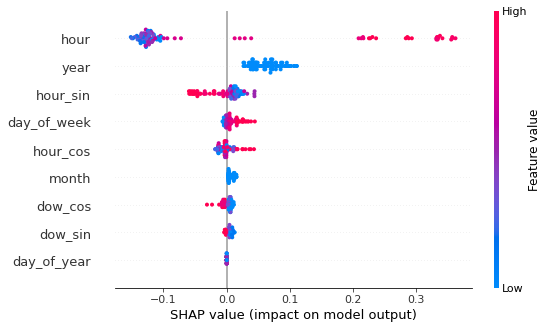

In [35]:
shap.summary_plot(np.array(shap_values[0]).reshape(100,9), features=np.array(X_test[:100]).reshape(100,9), feature_names=df_mt3.columns[df_mt3.columns != 'MT_3'])

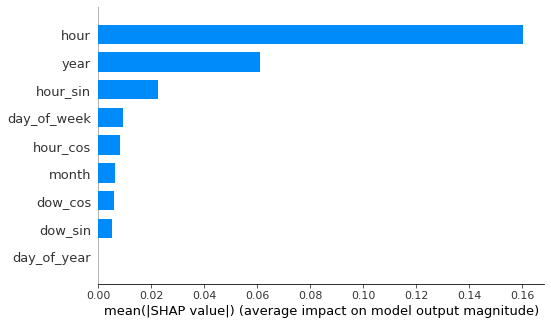

In [36]:
shap.summary_plot(np.array(shap_values[0]).reshape(100,9), features=np.array(X_test[:100]).reshape(100,9), feature_names=df_mt3.columns[df_mt3.columns != 'MT_3'], plot_type='bar')

## RF

In [37]:
data_series = Dataset["MT_3"].copy()
n_train = int(len(Dataset.MT_3) * data_split)
n_test = (len(Dataset) - n_train)
# look_back = 2
n_train, n_test

(17905, 3160)

In [38]:
# creating target and features for training set
X_train = np.array(df_mt3[:-n_test].loc[:, df_mt3.columns != 'MT_3'])
y_train = np.array(df_mt3[:-n_test].iloc[:, 0])
train_dates = Dataset_time[:-n_test]

# creating target and features for test set
X_test = np.array(df_mt3[-n_test:].loc[:, df_mt3.columns != 'MT_3'])
y_test_RF = np.array(df_mt3[-n_test:].iloc[:, 0])
test_dates = Dataset_time[-n_test:]

print(X_train.shape, y_train.shape, X_test.shape, y_test_RF.shape)

(17905, 9) (17905,) (3160, 9) (3160,)


In [39]:
RF_Model1 = RandomForestRegressor(n_estimators=1000, max_features=1, random_state=123)

In [40]:
labels = y_train
features = X_train
 
# Fit the RF model with features and labels.
rgr=RF_Model1.fit(X_train, y_train)
 
# Now that we've run our models and fit it, let's create
# dataframes to look at the results
predictions_RF=rgr.predict(X_test)

# plot of predictions and actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test_RF, line_shape='linear', 
              name = 'Ground Truth'))
fig.add_trace(go.Scatter(x=test_dates, y=predictions_RF, line_shape='linear', 
              name = 'Prediction'))
fig.show()    

# calculating RMSE metrics
error = np.sqrt(mean_squared_error(y_test_RF[:-1], y_test_RF[1:]))
print('Baseline RMSE: %.3f' % error)
error = np.sqrt(mean_squared_error(predictions_RF, y_test_RF))
print('Test RMSE: %.3f' % error)
print(error / np.mean(y_test_RF))

Baseline RMSE: 79.584
Test RMSE: 85.186
0.16538735232660562


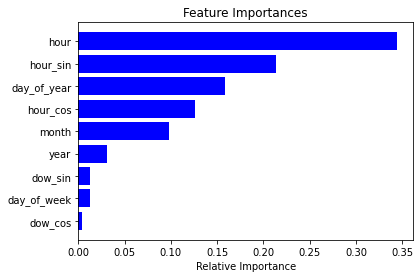

In [41]:
features = df_mt3.columns[df_mt3.columns != 'MT_3']
importances = rgr.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## GBR

In [42]:
GBR_Model1 = GradientBoostingRegressor(n_estimators=3000, max_features='auto', criterion='squared_error', random_state=123)

In [43]:
# Fit the RF model with features and labels.
gbr=GBR_Model1.fit(X_train, y_train)
 
# Now that we've run our models and fit it, let's create
# dataframes to look at the results
predictions_GBR=gbr.predict(X_test)

# plot of predictions and actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test_RF, line_shape='linear', 
              name = 'Ground Truth'))
fig.add_trace(go.Scatter(x=test_dates, y=predictions_GBR, line_shape='linear', 
              name = 'Prediction'))
fig.show()    

# calculating RMSE metrics
error = np.sqrt(mean_squared_error(y_test_RF[:-1], y_test_RF[1:]))
print('Baseline RMSE: %.3f' % error)
error = np.sqrt(mean_squared_error(predictions_GBR, y_test_RF))
print('Test RMSE: %.3f' % error)
print(error / np.mean(y_test_RF))

Baseline RMSE: 79.584
Test RMSE: 68.123
0.13225932991377962


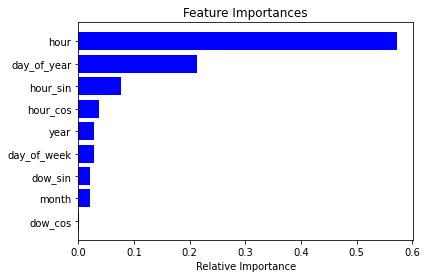

In [44]:
features = df_mt3.columns[df_mt3.columns != 'MT_3']
importances = gbr.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## XGB

In [45]:
import xgboost

In [46]:
XGB_Model1 = xgboost.XGBRegressor(n_estimators=1000, max_features=1, random_state=123)

In [47]:
labels = y_train
features = X_train
 
# Fit the RF model with features and labels.
xgb=XGB_Model1.fit(X_train, y_train)
 
# Now that we've run our models and fit it, let's create
# dataframes to look at the results
predictions_XGB=xgb.predict(X_test)

# plot of predictions and actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test_RF, line_shape='linear', 
              name = 'Ground Truth'))
fig.add_trace(go.Scatter(x=test_dates, y=predictions_XGB, line_shape='linear', 
              name = 'Prediction'))
fig.show()    

# calculating RMSE metrics
error = np.sqrt(mean_squared_error(y_test_RF[:-1], y_test_RF[1:]))
print('Baseline RMSE: %.3f' % error)
error = np.sqrt(mean_squared_error(predictions_XGB, y_test_RF))
print('Test RMSE: %.3f' % error)
print(error / np.mean(y_test_RF))

[04:14:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Baseline RMSE: 79.584
Test RMSE: 71.062
0.1379658527786796


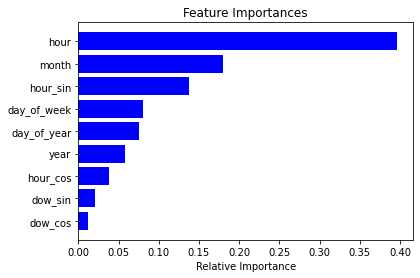

In [48]:
features = df_mt3.columns[df_mt3.columns != 'MT_3']
importances = xgb.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Evaluation

In [49]:
len(test_dates), len(y_test_RF), len(predictions_RF), len(predictions_GBR), len(predictions_XGB), len(pred_Inverse_LSTM), len(pred_Inverse_GRU)

(3160, 3160, 3160, 3160, 3160, 3160, 3160)

In [50]:
test_dates = test_dates.reset_index(drop='True')
test_dates.index

RangeIndex(start=0, stop=3160, step=1)

In [51]:
pd.concat([pd.DataFrame(list(test_dates), columns=['Timestamp']),
           pd.DataFrame(y_test_RF, columns=['Ground Truth']), 
           pd.DataFrame(predictions_GBR, columns=['GBR']), 
           pd.DataFrame(predictions_RF, columns=['RF']), 
           pd.DataFrame(predictions_XGB, columns=['XGB']),
           pd.DataFrame(pred_Inverse_LSTM, columns=['LSTM']),
           pd.DataFrame(pred_Inverse_GRU, columns=['GRU'])], axis=1).to_csv('/content/drive/MyDrive/Colab Notebooks/Research/no_lag_results.csv', index=False)

In [52]:
def calc_metrics(y_true, y_pred): 
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    nrmse = rmse / (np.mean(y_true))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mae, mape, rmse, nrmse

def return_metrics(Mape, Mae, Rmse, Nrmse):
  mape = str(round(np.mean(Mape), 2))+'%'+' +- '+str(round(np.std(Mape),2)) 
  mae = str(round(np.mean(Mae), 2)) + ' +- ' + str(round(np.std(Mae),2))
  rmse = str(round(np.mean(Rmse), 2)) + ' +- ' + str(round(np.std(Rmse),2))
  nrmse = str(round(np.mean(Nrmse), 2)) + ' +- ' + str(round(np.std(Nrmse),2))
  return mape, mae, rmse, nrmse

def generateValSet(test_size, sample_size):
  val_set = []
  i = 0
  while i < test_size:
    i += sample_size
    if i > test_size:
      i = test_size
      val_set.append(i)
      break
    val_set.append(i)
  return val_set

In [53]:
df_res = pd.DataFrame(columns=['model', 'hours', 'mape', 'mae', 'rmse', 'nrmse'])
df_res = df_res.astype(dtype= {"model":"string",
        "hours":"int","mape":"string", "mae":"string", "rmse":"string", "nrmse":"string"})
pred_hours = [1,6,12,24,48]

for hours in pred_hours:
  for model_name in ['RF', 'GBR', 'XGB', 'LSTM', 'GRU']:
    Mape = []
    Mae = []
    Rmse = []
    Nrmse = []
    
    val_set = None

    if model_name == 'RF':
      val_set = generateValSet(len(y_test_RF), hours)
      holdout = predictions_RF
      ground_truth = y_test_RF
    elif model_name == 'GBR':
      val_set = generateValSet(len(y_test_RF), hours)
      holdout = predictions_GBR
      ground_truth = y_test_RF
    elif model_name == 'XGB':
      val_set = generateValSet(len(y_test_RF), hours)
      holdout = predictions_XGB
      ground_truth = y_test_RF
    elif model_name=='LSTM':
      val_set = generateValSet(len(y_test_LSTM), hours)
      holdout = pred_Inverse_LSTM
      ground_truth = y_test_inverse_LSTM
    else:
      val_set = generateValSet(len(y_test_LSTM), hours)
      holdout = pred_Inverse_GRU
      ground_truth = y_test_inverse_GRU

    for val in val_set:
      forecast = holdout[:val]
      pred = forecast[-hours:]
      true = ground_truth[:val]
      actual = true[-hours:]
      mae, mape, rmse, nrmse = calc_metrics(actual, pred)
      Mape.append(mape)
      Mae.append(mae)
      Rmse.append(rmse)
      Nrmse.append(nrmse)
      
    metrics = return_metrics(Mape, Mae, Rmse, Nrmse)
    df_res = df_res.append({'model':model_name, 'hours': hours, 'mape': metrics[0], 'mae': metrics[1], 'rmse': metrics[2], 'nrmse': metrics[3]}, ignore_index=True)

In [55]:
df_res

,model,hours,mape,mae,rmse,nrmse
0,RF,1,0.13% +- 0.08,68.05 +- 51.24,68.05 +- 51.24,0.13 +- 0.08
1,GBR,1,0.11% +- 0.08,53.64 +- 42.0,53.64 +- 42.0,0.11 +- 0.08
2,XGB,1,0.11% +- 0.08,56.34 +- 43.31,56.34 +- 43.31,0.11 +- 0.08
3,LSTM,1,0.14% +- 0.12,66.57 +- 53.2,66.57 +- 53.2,0.14 +- 0.12
4,GRU,1,0.13% +- 0.09,66.99 +- 59.73,66.99 +- 59.73,0.13 +- 0.09
5,RF,6,0.13% +- 0.06,68.05 +- 37.31,75.95 +- 38.54,0.15 +- 0.06
6,GBR,6,0.11% +- 0.05,53.61 +- 28.85,60.91 +- 30.46,0.12 +- 0.05
7,XGB,6,0.11% +- 0.05,56.31 +- 28.22,64.32 +- 30.16,0.12 +- 0.05
8,LSTM,6,0.14% +- 0.08,66.55 +- 35.43,76.02 +- 38.44,0.15 +- 0.08
9,GRU,6,0.13% +- 0.06,66.96 +- 42.72,76.96 +- 46.13,0.15 +- 0.07


In [56]:
df_res.to_csv('/content/drive/MyDrive/Colab Notebooks/Research/no_lag_results_metrics.csv', index=False)

In [86]:
def plot_forecast(interval:int, hours:int, y_test, predictions_RF, predictions_GBR, predictions_XGB, pred_Inverse_LSTM, pred_Inverse_GRU):

  val_set = generateValSet(len(y_test), hours)
  if interval < 0 or interval > len(val_set):
    print(f"Please select between 1 and {len(val_set)}")

  low, high = val_set[interval-1]-hours, val_set[interval-1]

  forecast_rf = predictions_RF[low:high]
  forecast_gbr = predictions_GBR[low:high]
  forecast_xgb = predictions_XGB[low:high]
  forecast_lstm = [i[0] for i in pred_Inverse_LSTM[low:high]]
  forecast_gru = [i[0] for i in pred_Inverse_GRU[low:high]]
  true = y_test[low:high]

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=[i for i in range(1, hours+1)], y=true, mode='lines', line=dict(color='green'),
                name = 'Ground Truth'))
  fig.add_trace(go.Scatter(x=[i for i in range(1, hours+1)], y=forecast_rf, mode='lines', line=dict(color='blue'),
                name = 'RF'))
  fig.add_trace(go.Scatter(x=[i for i in range(1, hours+1)], y=forecast_gbr, mode='lines', line=dict(color='red'),
                name = 'GBR'))
  fig.add_trace(go.Scatter(x=[i for i in range(1, hours+1)], y=forecast_xgb, mode='lines', line=dict(color='orange'),
                name = 'XGB'))
  fig.add_trace(go.Scatter(x=[i for i in range(1, hours+1)], y=forecast_lstm, mode='lines', line=dict(color='yellow'),
                name = 'LSTM'))
  fig.add_trace(go.Scatter(x=[i for i in range(1, hours+1)], y=forecast_gru, mode='lines', line=dict(color='gray'),
                name = 'GRU'))
  
  fig.show()
  # pio.write_image(fig, "Images/RFx_Prediction.pdf", width=1000)

### 6 Hour Window

In [88]:
plot_forecast(11,6, y_test_RF, predictions_RF, predictions_GBR, predictions_XGB, pred_Inverse_LSTM, pred_Inverse_GRU)

### 12 Hour Window

In [89]:
plot_forecast(24,12, y_test_RF, predictions_RF, predictions_GBR, predictions_XGB, pred_Inverse_LSTM, pred_Inverse_GRU)

### 24 Hour Window

In [90]:
plot_forecast(11,24, y_test_RF, predictions_RF, predictions_GBR, predictions_XGB, pred_Inverse_LSTM, pred_Inverse_GRU)

### 48 Hour Window

In [91]:
plot_forecast(10,48, y_test_RF, predictions_RF, predictions_GBR, predictions_XGB, pred_Inverse_LSTM, pred_Inverse_GRU)

## Tree SHAP - GBR

In [ ]:
explainer = shap.TreeExplainer(model=gbr,
                               data=None,
                               model_output='raw',
                               feature_perturbation='tree_path_dependent')

In [ ]:
shap_values = explainer.shap_values(X_test)

In [ ]:
print(f'Shape of test dataset: {X_test.shape}')
print(f'Type of shap_values: {type(shap_values)}. Length of the list: {len(shap_values)}')
print(f'Shape of shap_values: {np.array(shap_values).shape}')

Shape of test dataset: (3160, 9)
Type of shap_values: <class 'numpy.ndarray'>. Length of the list: 3160
Shape of shap_values: (3160, 9)


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], features=X_test[0,:], feature_names=df_mt3.columns[df_mt3.columns != 'MT_3'])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100], features=X_test[:100,:], feature_names=df_mt3.columns[df_mt3.columns != 'MT_3'])

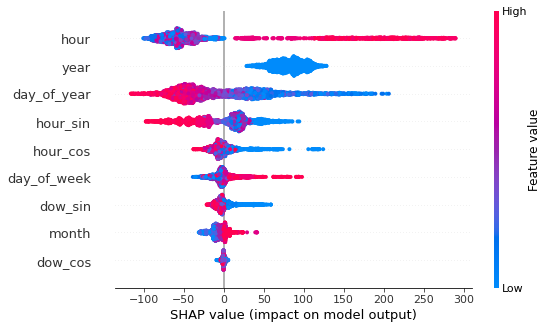

In [ ]:
shap.summary_plot(shap_values, features=X_test, feature_names=df_mt3.columns[df_mt3.columns != 'MT_3'])

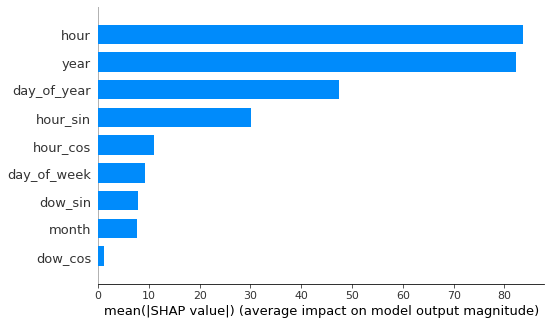

In [ ]:
shap.summary_plot(shap_values, features=X_test, feature_names=df_mt3.columns[df_mt3.columns != 'MT_3'], plot_type='bar')

# 24h Lag

## Dataset 

In [92]:
df_mt3_lag = Dataset.copy()

lag = 24

for l in range(1,lag+1):
  df_mt3_lag['lag_'+str(l)] = df_mt3_lag['MT_3'].shift(l)

df_mt3_lag.dropna(inplace=True)

df_mt3_lag.shape

(21041, 35)

In [93]:
Dataset_time = df_mt3_lag['timestamp']
df_mt3_lag.drop('timestamp', axis=1, inplace=True)
df_mt3_lag.head()

,MT_3,hour,month,year,day_of_week,day_of_year,dow_sin,dow_cos,hour_sin,hour_cos,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
24,462.0,0,1,2012,0,2,0.0,1.0,0.000000,1.000000,...,402.0,259.0,361.0,376.0,340.0,346.0,443.0,560.0,556.0,415.0
25,402.0,1,1,2012,0,2,0.0,1.0,0.258819,0.965926,...,446.0,402.0,259.0,361.0,376.0,340.0,346.0,443.0,560.0,556.0
26,376.0,2,1,2012,0,2,0.0,1.0,0.500000,0.866025,...,551.0,446.0,402.0,259.0,361.0,376.0,340.0,346.0,443.0,560.0
27,298.0,3,1,2012,0,2,0.0,1.0,0.707107,0.707107,...,532.0,551.0,446.0,402.0,259.0,361.0,376.0,340.0,346.0,443.0
28,253.0,4,1,2012,0,2,0.0,1.0,0.866025,0.500000,...,364.0,532.0,551.0,446.0,402.0,259.0,361.0,376.0,340.0,346.0


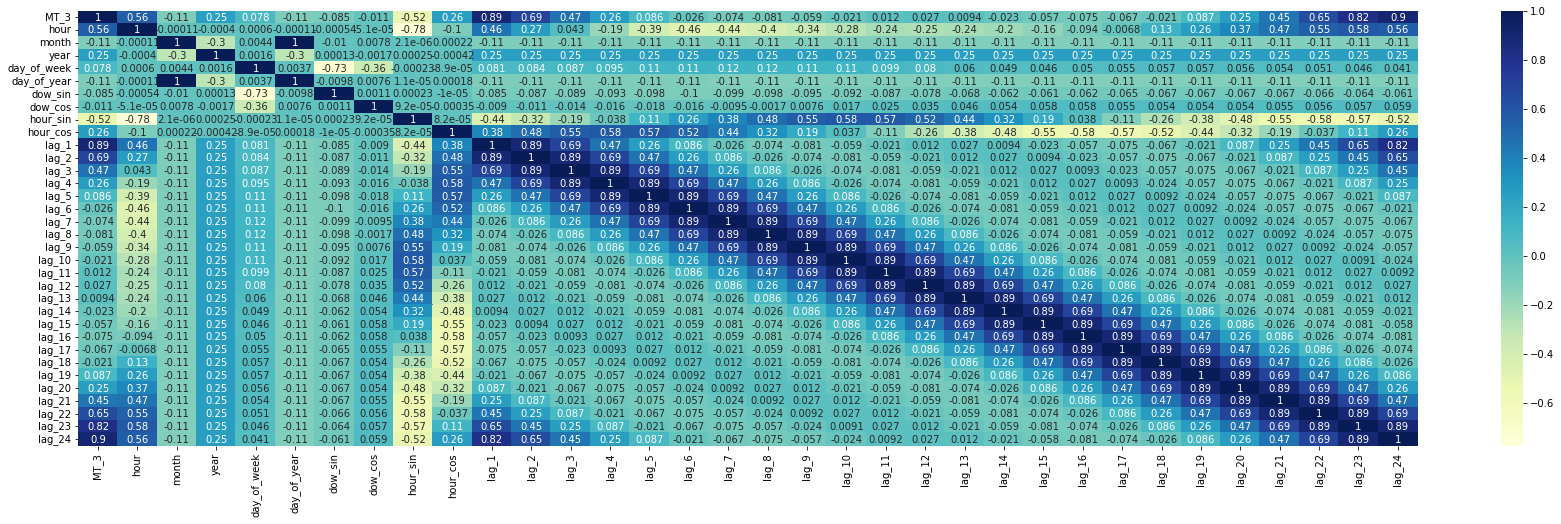

In [168]:
plt.figure(figsize=(30,8))
sns.heatmap(df_mt3_lag.corr(), cmap="YlGnBu", annot=True)
plt.show()

## LSTM

In [116]:
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(df_mt3_lag.iloc[:,1:])
Y_data = Y_scaler.fit_transform(df_mt3_lag['MT_3'].to_numpy().reshape(-1,1))

n_train = int(len(df_mt3_lag) * data_split)
n_test = (len(df_mt3_lag) - n_train)
print(n_train, n_test)

X_train = X_data[:-n_test]
y_train = Y_data[:-n_test]
train_dates_lstm = Dataset_time[:-n_test]

X_test = X_data[-n_test:]
y_test_LSTM = Y_data[-n_test:]
test_dates_lstm = Dataset_time[-n_test:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test_LSTM.shape)

17884 3157
(17884, 33, 1) (17884, 1) (3157, 33, 1) (3157, 1)


In [117]:
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 33, 200)           161600    
                                                                 
 lstm_6 (LSTM)               (None, 33, 100)           120400    
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 312,251
Trainable params: 312,251
Non-trainable params: 0
_________________________________________________________________


In [118]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((X_test, y_test_LSTM))
val_data = val_data.batch(batch_size).repeat() 

In [ ]:
model_path = 'LSTM_Multivariate_With_Lag.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 
history = model.fit(train_data,epochs=100,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Train on 100 steps, validate on 50 steps
Epoch 1/100
100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 0.1160

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


100/100 [==============================] - 17s 163ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1160 - val_loss: 0.1559
Epoch 2/100
100/100 [==============================] - 16s 164ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1054 - val_loss: 0.1260
Epoch 3/100
100/100 [==============================] - 15s 146ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1076 - val_loss: 0.1871
Epoch 4/100
100/100 [==============================] - 10s 96ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.1033 - val_loss: 0.1255
Epoch 5/100
100/100 [==============================] - 10s 95ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0853 - val_loss: 0.1044
Epoch 6/100
100/100 [==============================] - 10s 96ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0562 - val_loss: 0.0564
Epoch 7/100
100/100 [==============================] - 9s 92ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0564 - val_loss: 0.0551
Epoch 8/100
100/100 [==============================] - 9s 91ms/st

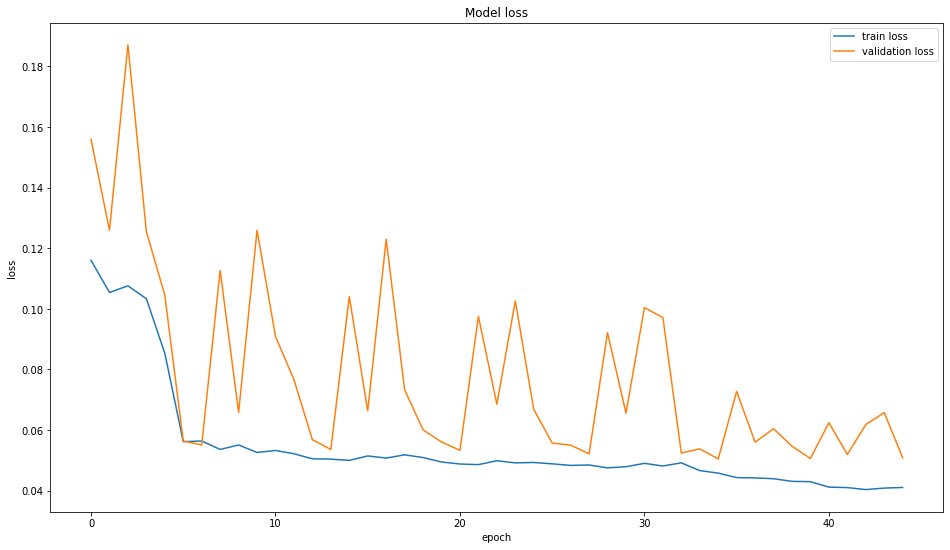

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

In [122]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Research/LSTM_Multivariate_With_Lag.h5')
model.evaluate(X_test, y_test_LSTM)

0.05019617347370645

In [123]:
y_pred_LSTM = model.predict(X_test)
pred_Inverse_LSTM = Y_scaler.inverse_transform(np.reshape(y_pred_LSTM, (y_pred_LSTM.shape[0], y_pred_LSTM.shape[1])))
y_test_inverse_LSTM = df_mt3_lag.iloc[-n_test:,0]

### Deep SHAP

In [124]:
explainer = shap.DeepExplainer(model, X_train[:1000])
shap_values = explainer.shap_values(X_test[:100], check_additivity=False)

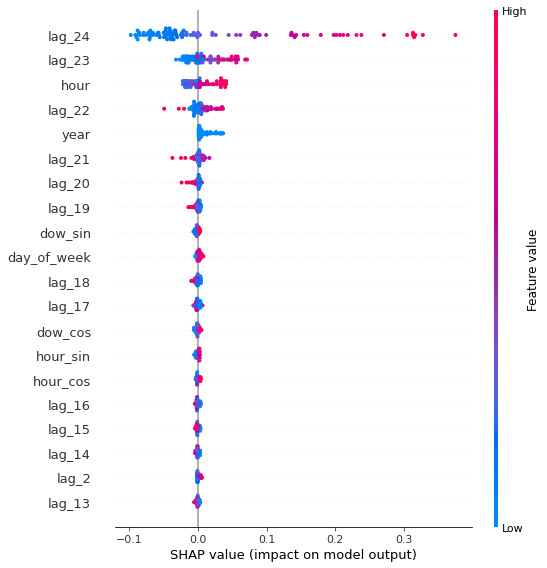

In [127]:
shap.summary_plot(np.array(shap_values[0]).reshape(100,33), features=np.array(X_test[:100]).reshape(100,33), feature_names=df_mt3_lag.columns[df_mt3_lag.columns != 'MT_3'])

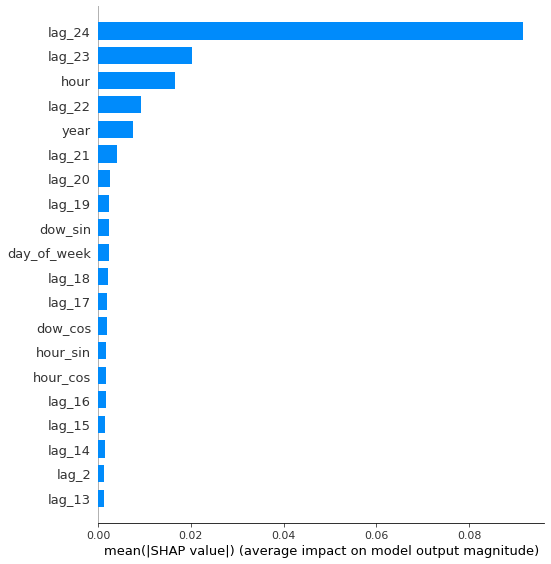

In [128]:
shap.summary_plot(np.array(shap_values[0]).reshape(100,33), features=np.array(X_test[:100]).reshape(100,33), feature_names=df_mt3_lag.columns[df_mt3_lag.columns != 'MT_3'], plot_type='bar')

## GRU

In [119]:
model = Sequential()
model.add(GRU(200, activation='relu', return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(GRU(100, activation='relu', return_sequences=True))
model.add(GRU(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 33, 200)           121800    
                                                                 
 gru_6 (GRU)                 (None, 33, 100)           90600     
                                                                 
 gru_7 (GRU)                 (None, 50)                22800     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 235,251
Trainable params: 235,251
Non-trainable params: 0
_________________________________________________________________


In [120]:
model_path = 'GRU_Multivariate_With_Lag.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 
history = model.fit(train_data,epochs=100,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

Train on 100 steps, validate on 50 steps
Epoch 1/100
100/100 [==============================] - 48s 468ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0973 - val_loss: 0.1023
Epoch 2/100
100/100 [==============================] - 41s 411ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0532 - val_loss: 0.0617
Epoch 3/100
100/100 [==============================] - 41s 413ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0476 - val_loss: 0.0594
Epoch 4/100
100/100 [==============================] - 41s 411ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0463 - val_loss: 0.0632
Epoch 5/100
100/100 [==============================] - 41s 411ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0463 - val_loss: 0.0844
Epoch 6/100
100/100 [==============================] - 41s 412ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0460 - val_loss: 0.0714
Epoch 7/100
100/100 [==============================] - 41s 411ms/step - batch: 49.5000 - size: 1.0000 - loss: 0.0462 - val_loss: 0.0571
Epoch 8

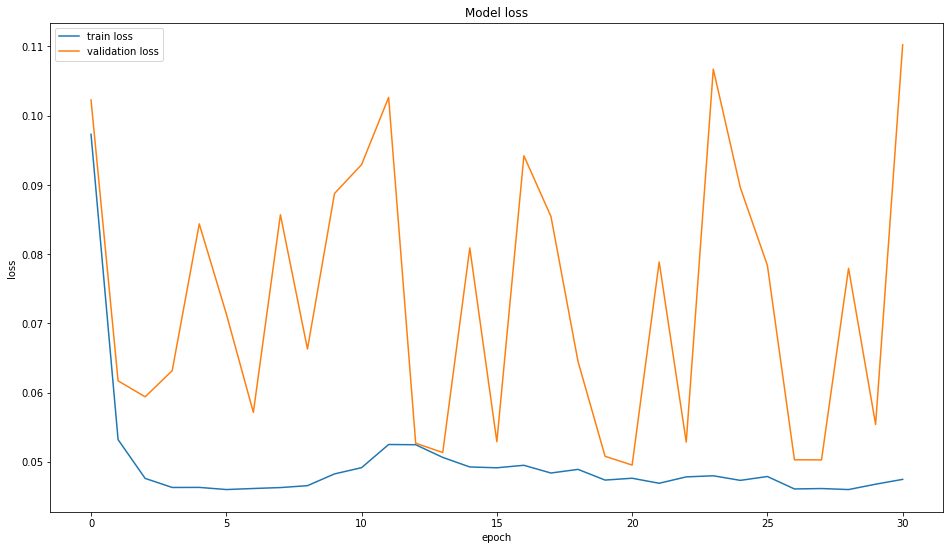

In [121]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

In [129]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/Research/GRU_Multivariate_With_Lag.h5')
model.evaluate(X_test, y_test_LSTM)

0.04924493924132585

In [130]:
y_pred_GRU = model.predict(X_test)
pred_Inverse_GRU = Y_scaler.inverse_transform(np.reshape(y_pred_GRU, (y_pred_GRU.shape[0], y_pred_GRU.shape[1])))
y_test_inverse_GRU = df_mt3_lag.iloc[-n_test:,0]

### Deep SHAP

In [131]:
explainer = shap.DeepExplainer(model, X_train[:1000])
shap_values = explainer.shap_values(X_test[:100], check_additivity=False)

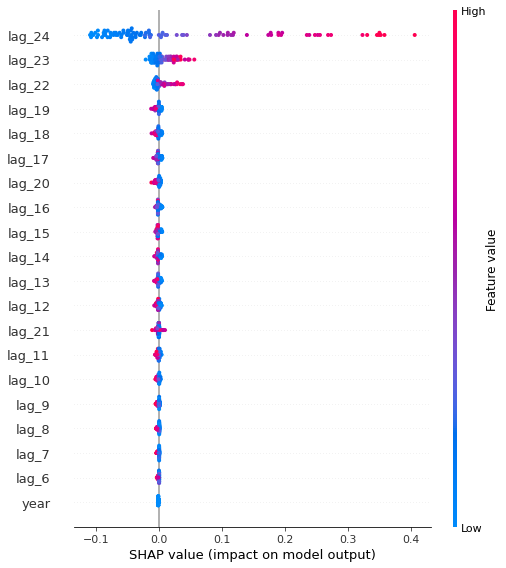

In [132]:
shap.summary_plot(np.array(shap_values[0]).reshape(100,33), features=np.array(X_test[:100]).reshape(100,33), feature_names=df_mt3_lag.columns[df_mt3_lag.columns != 'MT_3'])

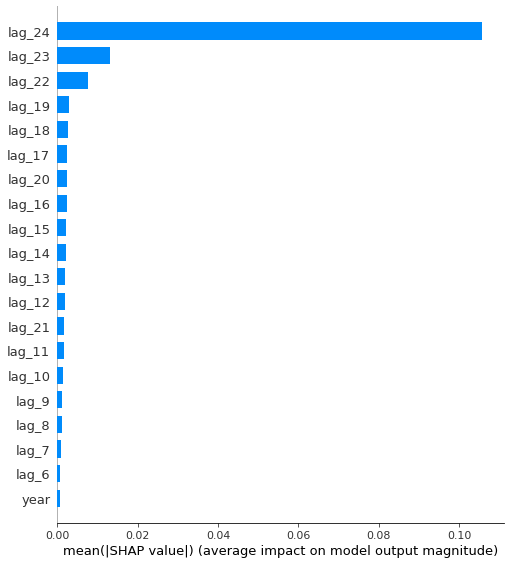

In [133]:
shap.summary_plot(np.array(shap_values[0]).reshape(100,33), features=np.array(X_test[:100]).reshape(100,33), feature_names=df_mt3_lag.columns[df_mt3_lag.columns != 'MT_3'], plot_type='bar')

## Evaluation

In [134]:
df_res = pd.DataFrame(columns=['model', 'hours', 'mape', 'mae', 'rmse', 'nrmse'])
df_res = df_res.astype(dtype= {"model":"string",
        "hours":"int","mape":"string", "mae":"string", "rmse":"string", "nrmse":"string"})
pred_hours = [1,6,12,24,48]

for hours in pred_hours:
  for model_name in ['LSTM', 'GRU']:
    Mape = []
    Mae = []
    Rmse = []
    Nrmse = []
    
    val_set = None

    if model_name == 'LSTM':
      val_set = generateValSet(len(y_test_LSTM), hours)
      holdout = pred_Inverse_LSTM
      ground_truth = y_test_inverse_LSTM
    else:
      val_set = generateValSet(len(y_test_LSTM), hours)
      holdout = pred_Inverse_GRU
      ground_truth = y_test_inverse_GRU

    for val in val_set:
      forecast = holdout[:val]
      pred = forecast[-hours:]
      true = ground_truth[:val]
      actual = true[-hours:]
      mae, mape, rmse, nrmse = calc_metrics(actual, pred)
      Mape.append(mape)
      Mae.append(mae)
      Rmse.append(rmse)
      Nrmse.append(nrmse)
      
    metrics = return_metrics(Mape, Mae, Rmse, Nrmse)
    df_res = df_res.append({'model':model_name, 'hours': hours, 'mape': metrics[0], 'mae': metrics[1], 'rmse': metrics[2], 'nrmse': metrics[3]}, ignore_index=True)

In [135]:
df_res

,model,hours,mape,mae,rmse,nrmse
0,LSTM,1,0.1% +- 0.1,51.0 +- 48.94,51.0 +- 48.94,0.1 +- 0.1
1,GRU,1,0.1% +- 0.1,50.03 +- 49.71,50.03 +- 49.71,0.1 +- 0.1
2,LSTM,6,0.1% +- 0.07,50.97 +- 34.36,59.67 +- 37.81,0.12 +- 0.08
3,GRU,6,0.1% +- 0.07,49.97 +- 35.78,58.62 +- 39.11,0.12 +- 0.07
4,LSTM,12,0.1% +- 0.06,50.92 +- 28.45,62.34 +- 33.12,0.12 +- 0.07
5,GRU,12,0.1% +- 0.06,49.93 +- 29.95,61.39 +- 34.5,0.12 +- 0.07
6,LSTM,24,0.1% +- 0.04,50.92 +- 21.27,64.78 +- 28.04,0.13 +- 0.05
7,GRU,24,0.1% +- 0.04,49.95 +- 22.83,63.91 +- 29.6,0.12 +- 0.05
8,LSTM,48,0.1% +- 0.03,50.91 +- 15.39,66.96 +- 22.31,0.13 +- 0.04
9,GRU,48,0.1% +- 0.03,49.99 +- 16.06,66.44 +- 23.41,0.13 +- 0.04


In [136]:
df_res.to_csv('/content/drive/MyDrive/Colab Notebooks/Research/lag_results_metrics.csv', index=False)